In [36]:
import pandas as pd
import os
import functions as fn

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict, plot_acf, plot_pacf

import scipy.stats as st
import scipy as sp


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
#Define figure sizes
plt.rcParams.update({'figure.figsize': (10, 10), 'figure.dpi': 120})

In [37]:
# Read all years in DataBase folder
df_final=fn.read_all_years('../DataBase')
df_final.columns

Folder 2018 read successfully
Folder 2019 read successfully
Folder 2020 read successfully
Folder 2021 read successfully
Folder 2022 read successfully
Folder 2023 read successfully


Index(['MUNICIPIO', 'ESTACION', 'MAGNITUD', 'date', 'station', 'hour', 'H',
       'V'],
      dtype='object')

In [38]:
df_predict=df_final.loc[df_final["V"]=='V'].groupby(["date"]).agg({"H":"mean"}).rename(columns={'H':'mean_H'})
# Retirar los últimos 15 días para luego hacer la predicción
df_predict15=df_predict.iloc[:-15]

In order to predict the future behaviour one must first have all the data history lines, in this case the database has values from 2018 t0 2023. Predicting a values in different stations can be a solution, for each station a prediction model can be run to predict future behviour. On the other hand an average value can be calculated and from that point a global average value can be predict for a specific day.  
  
In this case, an average value for a day will be calculated and predicted using various models. However, there is an issue for the values that are not valid, that problem will be solved using a regression model to extract those values. 

### Predicting the next three days ahead

c:\Users\juano\Documents\Trabajos\Proyectos\ContaminationMadrid\ENVContaminacion\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


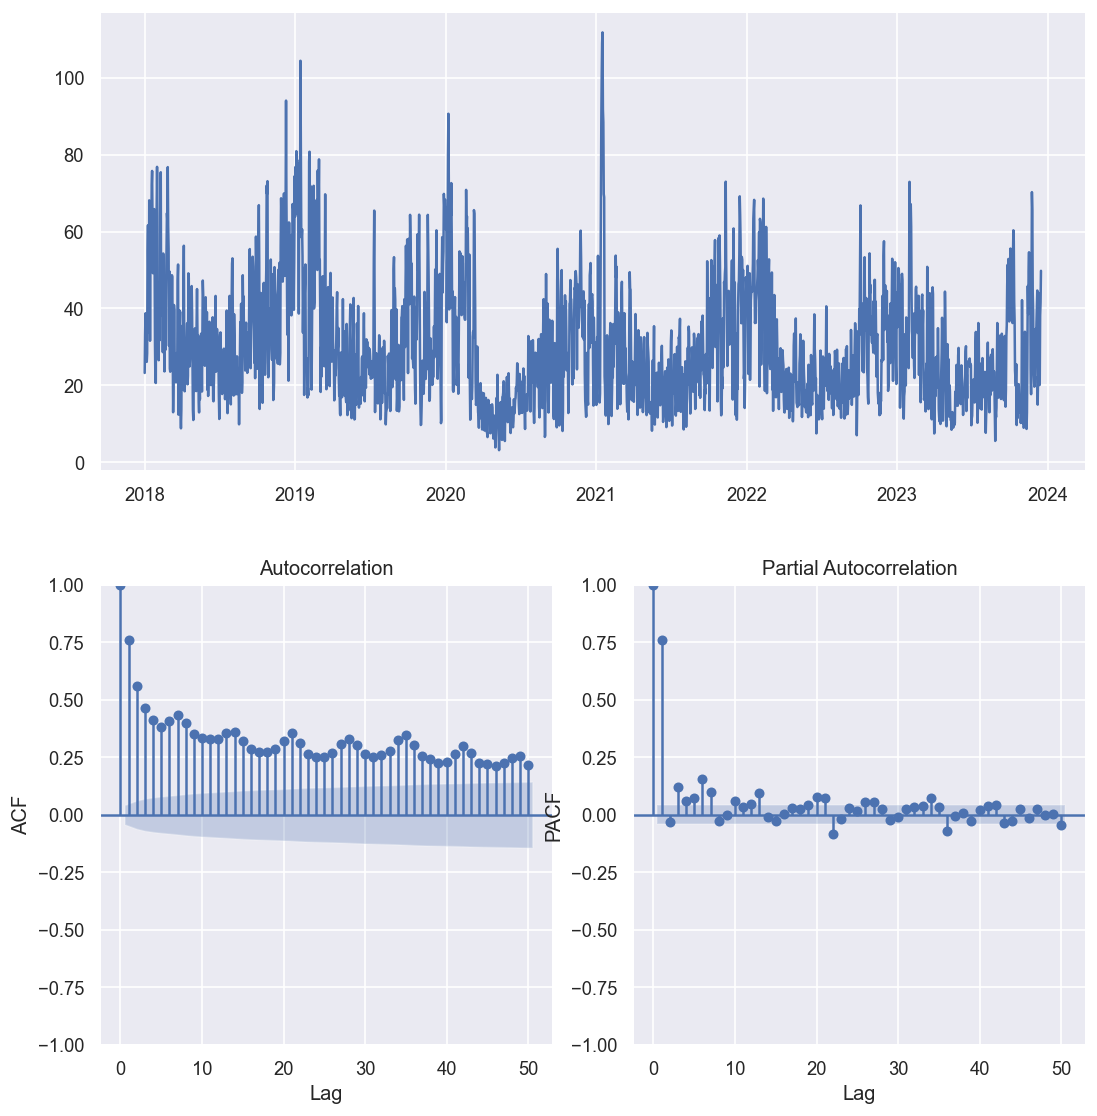

In [128]:
from mltools import forecast_tools as FT

FT.ts_display(df_predict15, lags=50)

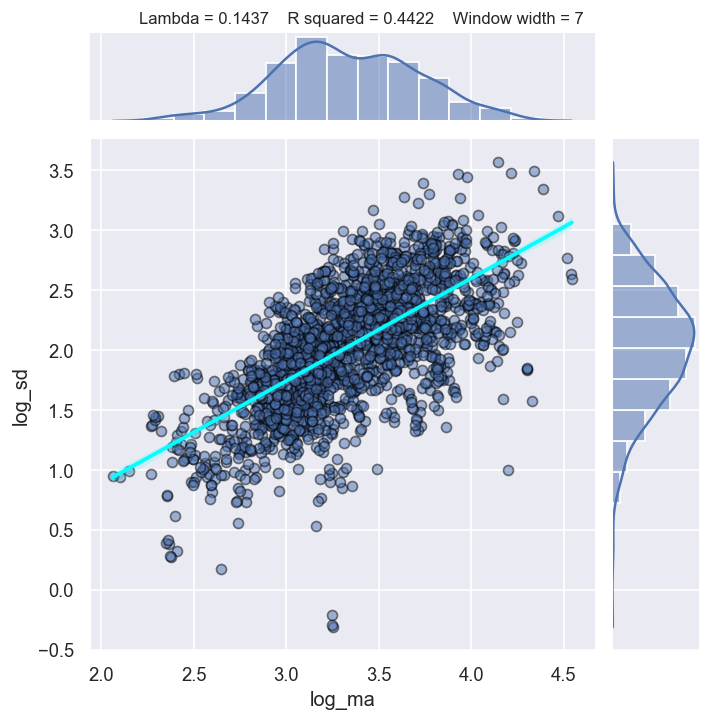

In [129]:
# Box-cox transformation
lmbda = FT.boxcox_lambda_plot(df_predict15, window_width=7)

c:\Users\juano\Documents\Trabajos\Proyectos\ContaminationMadrid\ENVContaminacion\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


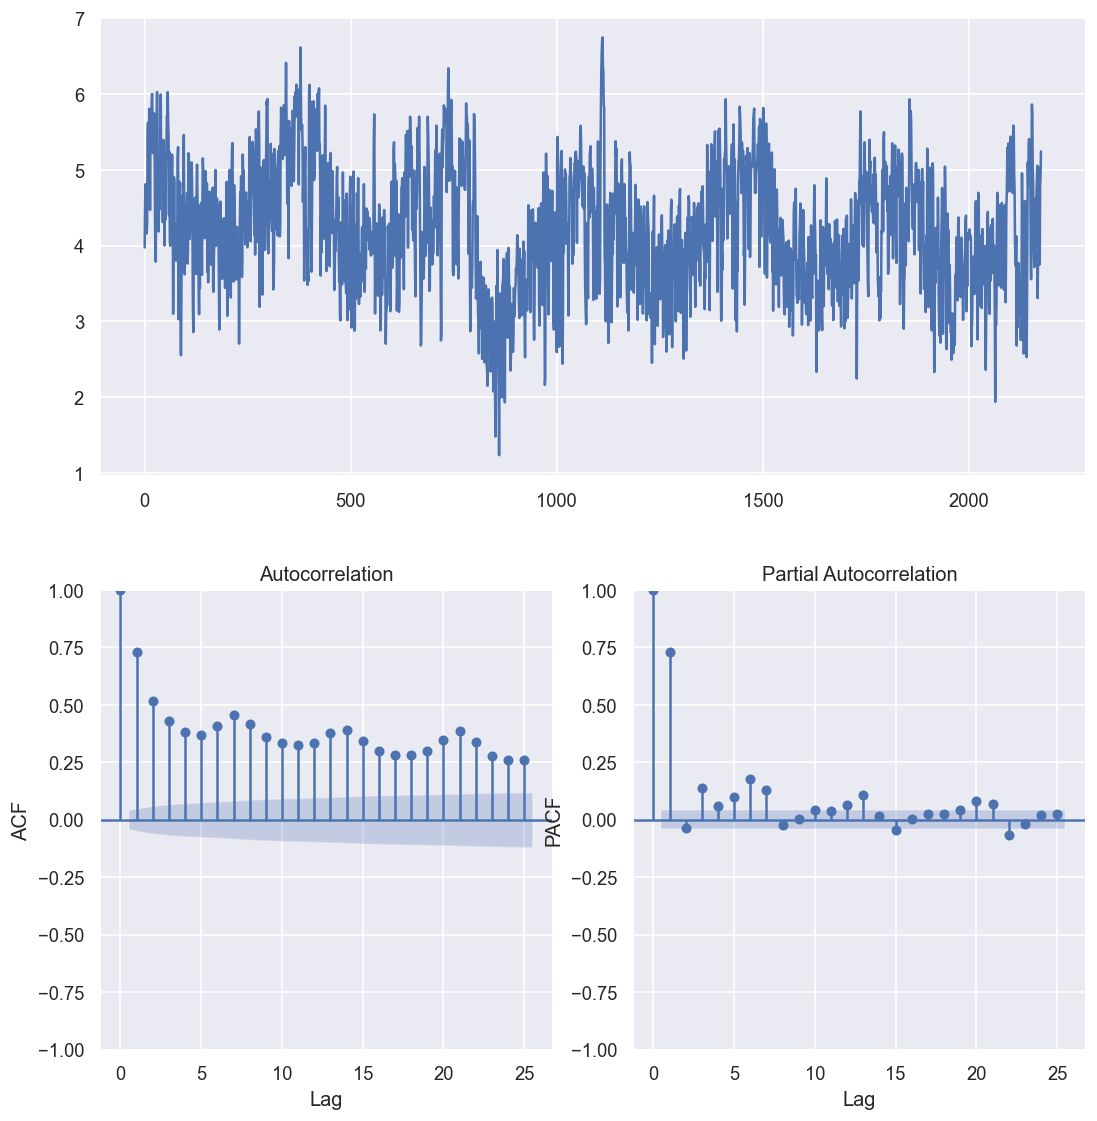

In [130]:
BOX_COX = True
if BOX_COX:
    lmbda = 0.1437
    z = st.boxcox(df_predict15.values[:,0], lmbda = lmbda) #Convert to positive
    #z,lmbda = st.boxcox(df_predict.values[:,0] - min(df_predict.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_predict15.columns.values.tolist())
else:
    z = df_predict15

FT.ts_display(z)

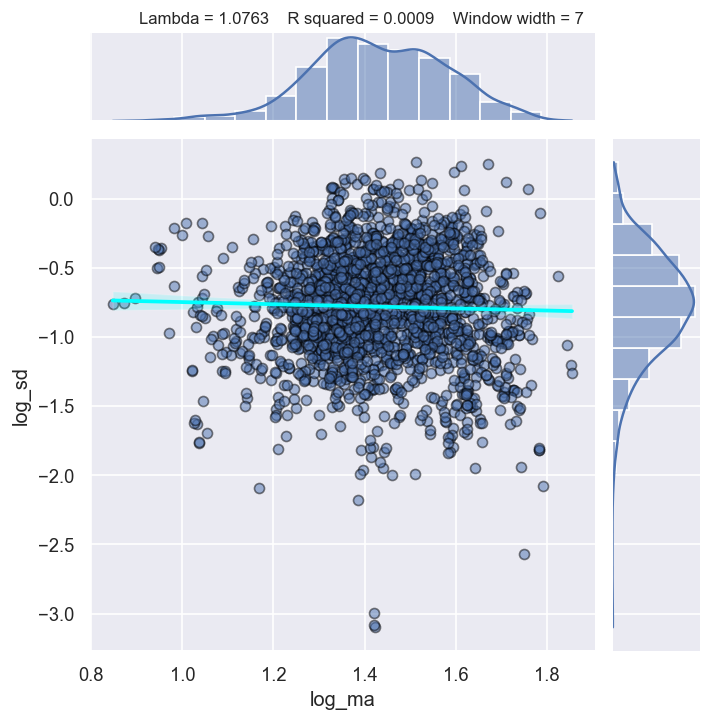

1.0763109605834593

In [131]:
FT.boxcox_lambda_plot(z, window_width=7)

In [132]:
''' 
With the Alternative test - Augmented Dickey Fuller Test i can deteminr if the time series is stationary or not

- A stationary series has constant mean and variance over time so it is easier to predict the future values.
- If H0 condition has a p-value less than 0.05, then the series is stationary.
- As the ADF values is less than the critical values, the null hypothesis is rejected and the series is stationary.
- There is less than 1% chance that the null hypothesis(the series is not statonary) is true.
'''
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.073284
p-value: 0.001072
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


c:\Users\juano\Documents\Trabajos\Proyectos\ContaminationMadrid\ENVContaminacion\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


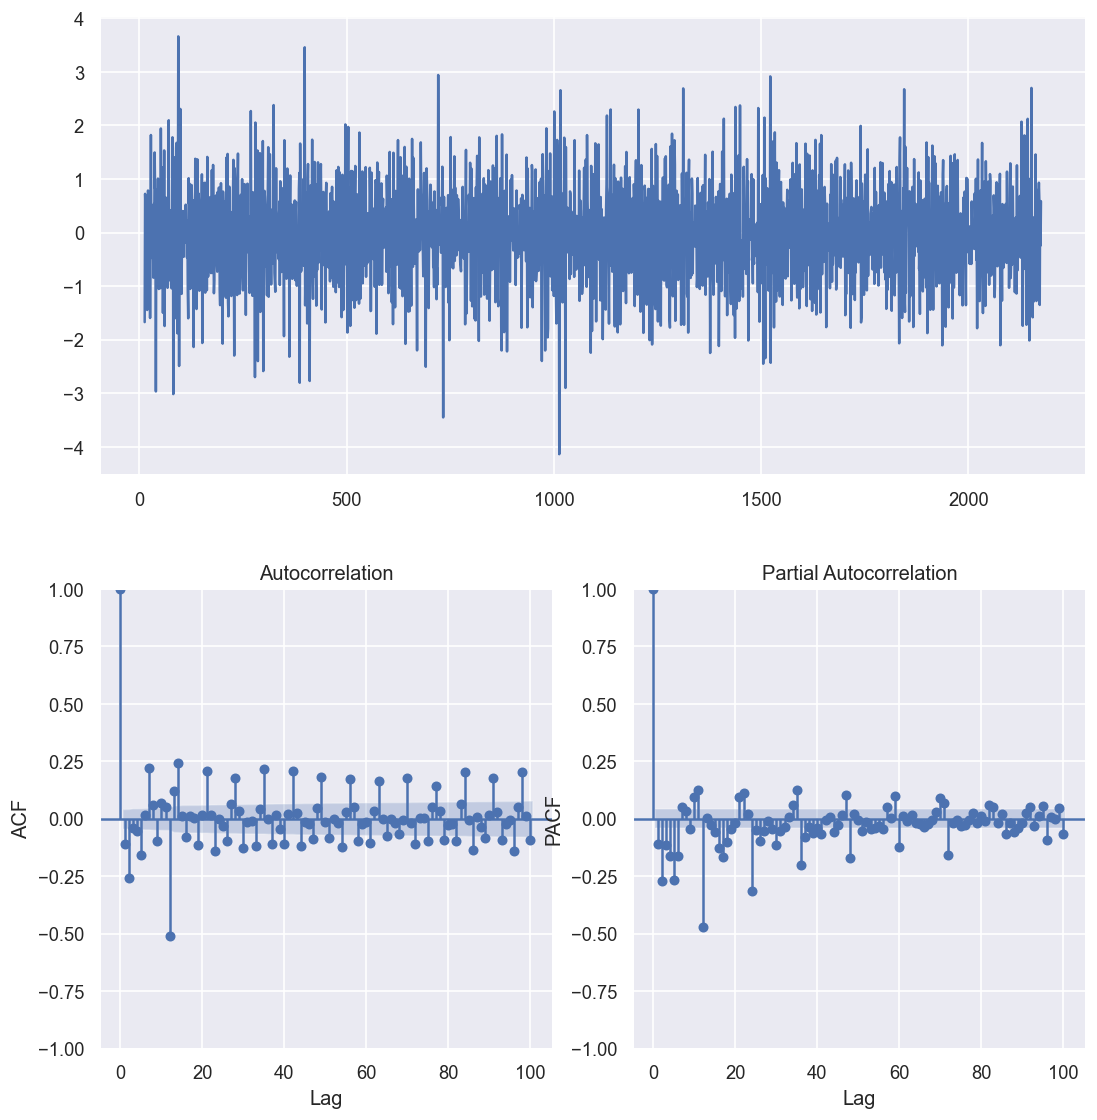

In [133]:
# Difference of the time series
d = 1 # Diference in the real time series, is the difference between y_t and y_(t-1)
D = 1 # Diference in the seasonality of the time series, is the difference between y_t and y_(t-S)
S = 12 # Seasonality of 12 days
# predigo el incremento que va a hacer mañana en base a ayer y antes de ayer--> Ejemplo 
Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=100)

In [134]:
# Fit model with estimated order
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_fit = SARIMAX(z, 
                    order=(2,0,2), # Regular components (AR,s,MA) --> AR->PACF, MA->ACF
                    seasonal_order=(1, 0, 1, 7),# Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarima_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              mean_H   No. Observations:                 2176
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -1617.549
Date:                             Tue, 13 Feb 2024   AIC                           3249.097
Time:                                     07:49:06   BIC                           3288.862
Sample:                                          0   HQIC                          3263.639
                                            - 2176                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4273      0.042     34.007      0.000       1.345       1.510
ar.L2         -0.4352      

c:\Users\juano\Documents\Trabajos\Proyectos\ContaminationMadrid\ENVContaminacion\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


All the coeficients are below 0.05 therefore are relevant and important, however the best way to find the best combination is to observe the ACF and PACF, the first one goes by a seasonality of 7 days and the second by the 12 month period. Between the two I initially chose the 12 month period but the models had to problems, they were more complicated and the residual error(plotted after this text) was not white noise therefore some information was missing.  
The three steps to check are:
- The ACF and PACF graphs to detail the seasonality and the order of the series
- Check for relevant variables P>|z| less than 0.05
- Build the simplest model (check the Jarque-Bera (JB) parameter)
- Check the residuals to be white noise( if there are more than one model with one noise it is common practice to choose the simplest one)

c:\Users\juano\Documents\Trabajos\Proyectos\ContaminationMadrid\ENVContaminacion\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  19.784518   0.758035


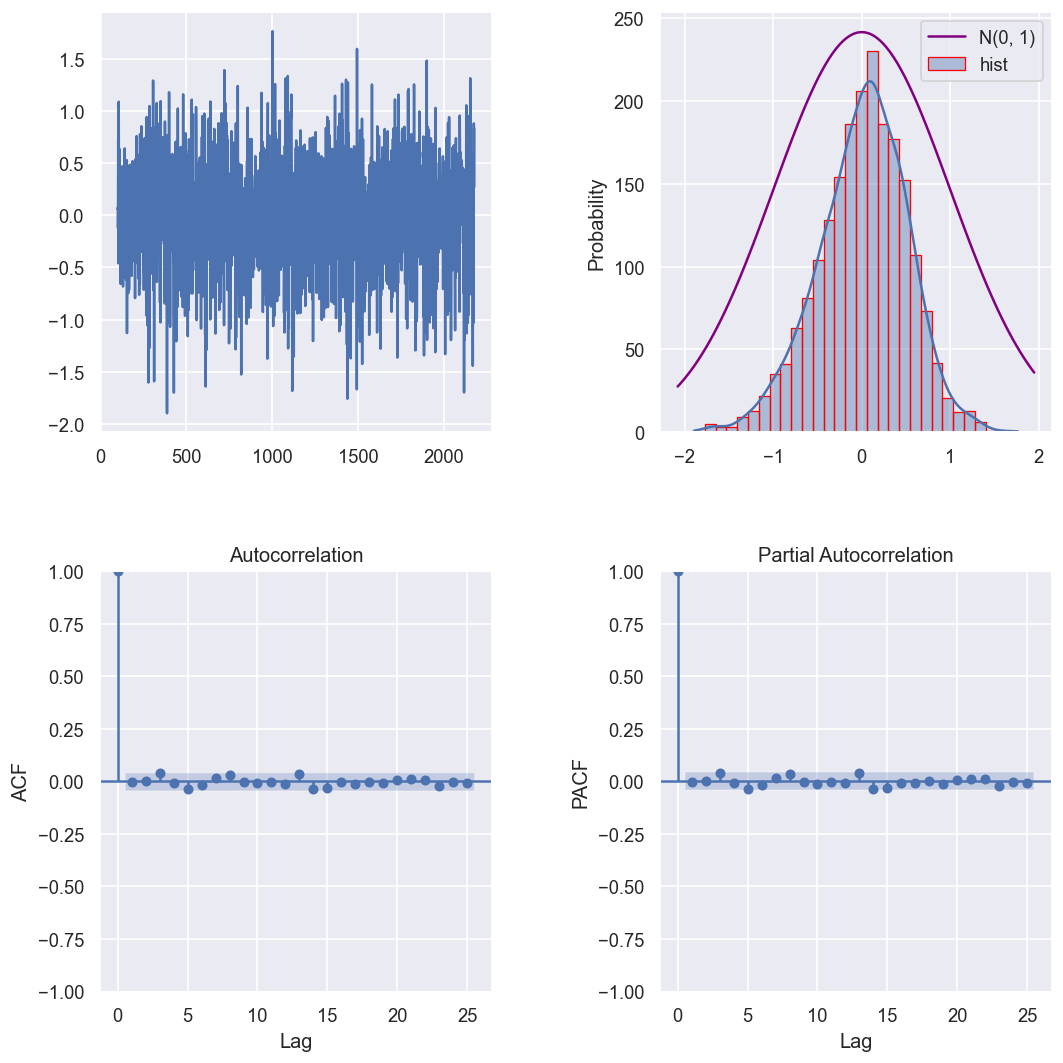

In [135]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))

In [136]:
max_date = df_predict15.index.max()
print("Fecha máxima:", max_date)

Fecha máxima: 2023-12-16 00:00:00


In [146]:
from scipy.special import inv_boxcox
# Realizar predicciones para los próximos 15 días
predicciones = sarima_fit.forecast(steps=15)
predictions_real = inv_boxcox(predicciones, lmbda)

# Convertir las predicciones a DataFrame
pred_df = pd.DataFrame(columns=['Predictions'])
pred_df['Predictions']=predictions_real
pred_df["date"] = pd.date_range(start=max_date+pd.DateOffset(1), periods=15).tolist()
pred_df.set_index('date', inplace=True)

,Predictions
date,
2023-12-17,34.727605
2023-12-18,36.839503
2023-12-19,35.808689
2023-12-20,34.058143
2023-12-21,33.636358
2023-12-22,31.720016
2023-12-23,26.719252
2023-12-24,23.467423
2023-12-25,30.463877


In [149]:
# Compare the real values with the predicted values
# get the last 15 days real values from df_predict
real_values = df_predict.iloc[-15:]
# Calculate the error between the real values and the predicted values
# Match both df by index
merged_df = pred_df.merge(real_values, left_index=True, right_index=True, how='inner')


,Predictions,mean_H
date,,
2023-12-17,34.727605,47.300347
2023-12-18,36.839503,60.092362
2023-12-19,35.808689,63.533688
2023-12-20,34.058143,35.438938
2023-12-21,33.636358,63.456790
2023-12-22,31.720016,59.261404
2023-12-23,26.719252,47.433798
2023-12-24,23.467423,41.087566
2023-12-25,30.463877,39.630208


In [151]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(merged_df['mean_H'], merged_df['Predictions'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(merged_df['mean_H'], merged_df['Predictions'])

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((merged_df['mean_H'] - merged_df['Predictions']) / merged_df['mean_H'])) * 100

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Squared Error (MSE): 470.1986068752088
Root Mean Squared Error (RMSE): 21.684063430898018
Mean Absolute Error (MAE): 19.744037911536047
Mean Absolute Percentage Error (MAPE): 36.905635188249356


The resulting errors indicate that the model's performance is not satisfactory. This could be attributed to various factors, such as the dynamic nature of environmental conditions each year, which may include variables like weekends, holidays, and other factors influencing pollution levels. Additionally, predicting pollution levels during certain periods, such as around Christmas, can be particularly challenging.

One notable example of the model's limitations is the impact of the 2020 COVID-19 pandemic, which led to significant reductions in pollution levels. While such events are important to consider, they should not overly influence the model's learning process to prevent bias.

To improve the model's performance, several strategies can be considered. One approach is to explore the use of the Prophet model, a forecasting tool developed by Facebook that can handle seasonality and holiday effects. Additionally, it may be beneficial to preprocess the data and address potential issues with problematic dates.

Another option is to build a standard regression model using advanced techniques such as grid search with the MLPRegressor from the scikit-learn library. This approach allows for fine-tuning the model hyperparameters to optimize performance.

Furthermore, leveraging tree-based models like XGBoost can be effective, as they excel in handling complex relationships in the data and are robust against outliers.